<a href="https://colab.research.google.com/github/ssec/WAF_ML_Tutorial_Part2/blob/main/colab_notebooks/Notebook07_CNNs_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Notebook 07: Convolutional Neural Networks



### Primary Goal:
Build and train a convolutional neural network



#### Background
Now that we have thoroughly discussed what a convolution is, here we will dive into training a convolutional neural network on the ```sub-sevir``` dataset.



#### Step 0
As with all of our notebooks, we will first install packages and grab data



**Note: downloading the data can take up to 15-20 mins depending on the server speed. Please be patient**

In [1]:
#@title Install and unpack files [this will take some time]

print('installing dependencies')
!pip -q install zenodo-get
!pip -q install zarr
print('grabbing sub-sevir')
!zenodo_get 7011372
print('unpacking sub-sevir')
!tar -xf sub-sevir.tar.gz
!tar -xf sub-sevir/sub-sevir-train.tar.gz -C sub-sevir/
!tar -xf sub-sevir/sub-sevir-val.tar.gz -C sub-sevir/
!tar -xf sub-sevir/sub-sevir-test.tar.gz -C sub-sevir/
print('grabbing the Github repo')
!git clone https://github.com/ssec/WAF_ML_Tutorial_Part2.git
print('done')


installing dependancies
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.3/252.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 97.5 MB/s eta 0:00:00
grabbing sub-sevir
Title: sub-SEVIR
Keywords: 
Publication date: 2022-09-28
DOI: 10.5281/zenodo.7011372
Total size: 2.0 GB

File: sub-sevir.tar.gz (2.0 GB)
Link: https://zenodo.org/api/records/7011372/files/sub-sevir.tar.gz/content

Checksum is correct for sub-sevir.tar.gz. (94ae916d24224500c2f531bb61440dab)

All specified files have been processed.
unpacking sub-sevir
grabbing the Github repo
Cloning into 'WAF_ML_Tutorial_Part2'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 167 (delta 7), reused 16 (delta 4), pack-reused 143 (from 1)
Receiving objects: 100% (167/167), 110.23 MiB | 24

 #### Step 1: Imports

In [64]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#plot parameters that I personally like, feel free to make these your own.
import matplotlib
import matplotlib.patheffects as path_effects


#outlines for text
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]

matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['legend.facecolor'] = 'w'
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
print(f"Set random seed: {seed}")

Using device: cpu
Set random seed: 42


 #### Step 2: Load in ```sub-sevir```



 You'll need to update the following paths to the location where you downloaded the data from Notebook 1.

In [34]:
ds_train = xr.open_dataset('sub-sevir/sub-sevir-train.zarr',engine='zarr')
ds_val = xr.open_dataset('sub-sevir/sub-sevir-val.zarr',engine='zarr')


 By design the ```sub-sevir``` data are 'machine learning ready'. This means that the normalization has already been done (i.e., the features have mean 0 and std 1) and the data are already split into the required groups (train/val/test). So in terms of preparing the data, we only have to pick what features we want to use for training and decide what the learning task is (i.e., classification/regression).



 #### Step 3: Convert data into PyTorch Datasets



 Before training a machine learning model, we must first convert the data from xarray to PyTorch `Dataset` and `DataLoader` objects. The first task in this tutorial will be a classification (i.e., "Does this image contain a thunderstorm?"), so we will choose the ```label_1d_class``` variable as our truth data.



 **Important Note:** PyTorch expects images in the channel-first format: `(Channels, Height, Width)`, whereas the data comes in `(Height, Width, Channels)`. We will handle this permutation in our custom Dataset class.

In [35]:
ds_train


<xarray.Dataset> Size: 3GB
Dimensions:         (n_samples: 60000, x: 48, y: 48, n_channel: 4)
Coordinates:
  * n_samples       (n_samples) datetime64[ns] 480kB 2018-08-25T00:15:00 ... ...
  * n_channel       (n_channel) <U5 80B 'ir069' 'ir107' 'vil' 'vis'
    id              (n_samples) object 480kB ...
Dimensions without coordinates: x, y
Data variables:
    features        (n_samples, x, y, n_channel) float32 2GB ...
    label_1d_class  (n_samples) int8 60kB ...
    label_1d_reg    (n_samples) int16 120kB ...
    label_2d_class  (n_samples, x, y) int8 138MB ...
    label_2d_reg    (n_samples, x, y) int16 276MB ...

In [36]:
class SubSevirDataset(Dataset):
    def __init__(self, xarray_dataset):
        self.features = xarray_dataset.features.values
        self.labels = xarray_dataset.label_1d_class.values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Grab data for index
        x = self.features[idx] # Shape: (48, 48, 4)
        y = self.labels[idx]   # Shape: (1,) or scalar

        # Convert to torch tensor
        x = torch.from_numpy(x).float()
        y = torch.tensor(y).float()

        # Permute to (Channels, Height, Width) -> (4, 48, 48)
        x = x.permute(2, 0, 1)

        return x, y

# Create Datasets
train_dataset = SubSevirDataset(ds_train)
val_dataset = SubSevirDataset(ds_val)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


 #### Step 4: Reminder of `DataLoader`



 The concept of a DataLoader is central to PyTorch.



 To help the machine learning converge on a solution in a timely manner, we first estimate how to adjust the weights of the model (i.e., the gradient of the model with respect to the error) on some *random subset* of the total training data (i.e., batch). This is accomplished by shuffling the data every epoch and randomly selecting batches. PyTorch's `DataLoader` class handles this batching and shuffling for us.



 Frequently asked question: "How do I look at the data stored in a `DataLoader`?"



 We can *iterate* over this loader. The following code will loop once to get the first batch.

In [37]:
# Get a single batch
data_iter = iter(train_loader)
features_batch, labels_batch = next(data_iter)


In [38]:
# Check shapes
print("Features shape:", features_batch.shape) # Should be [32, 4, 48, 48]
print("Labels shape:", labels_batch.shape)     # Should be [32]


Features shape: torch.Size([32, 4, 48, 48])
Labels shape: torch.Size([32])


 Now you can see that a batch is a collection of 32 images and labels. Note the shape `[32, 4, 48, 48]` which corresponds to `[Batch, Channels, Height, Width]`.



 We can visualize just one example to show the whole process. We need to permute the dimensions back to `[Height, Width, Channels]` for matplotlib plotting.

Label: 1.0


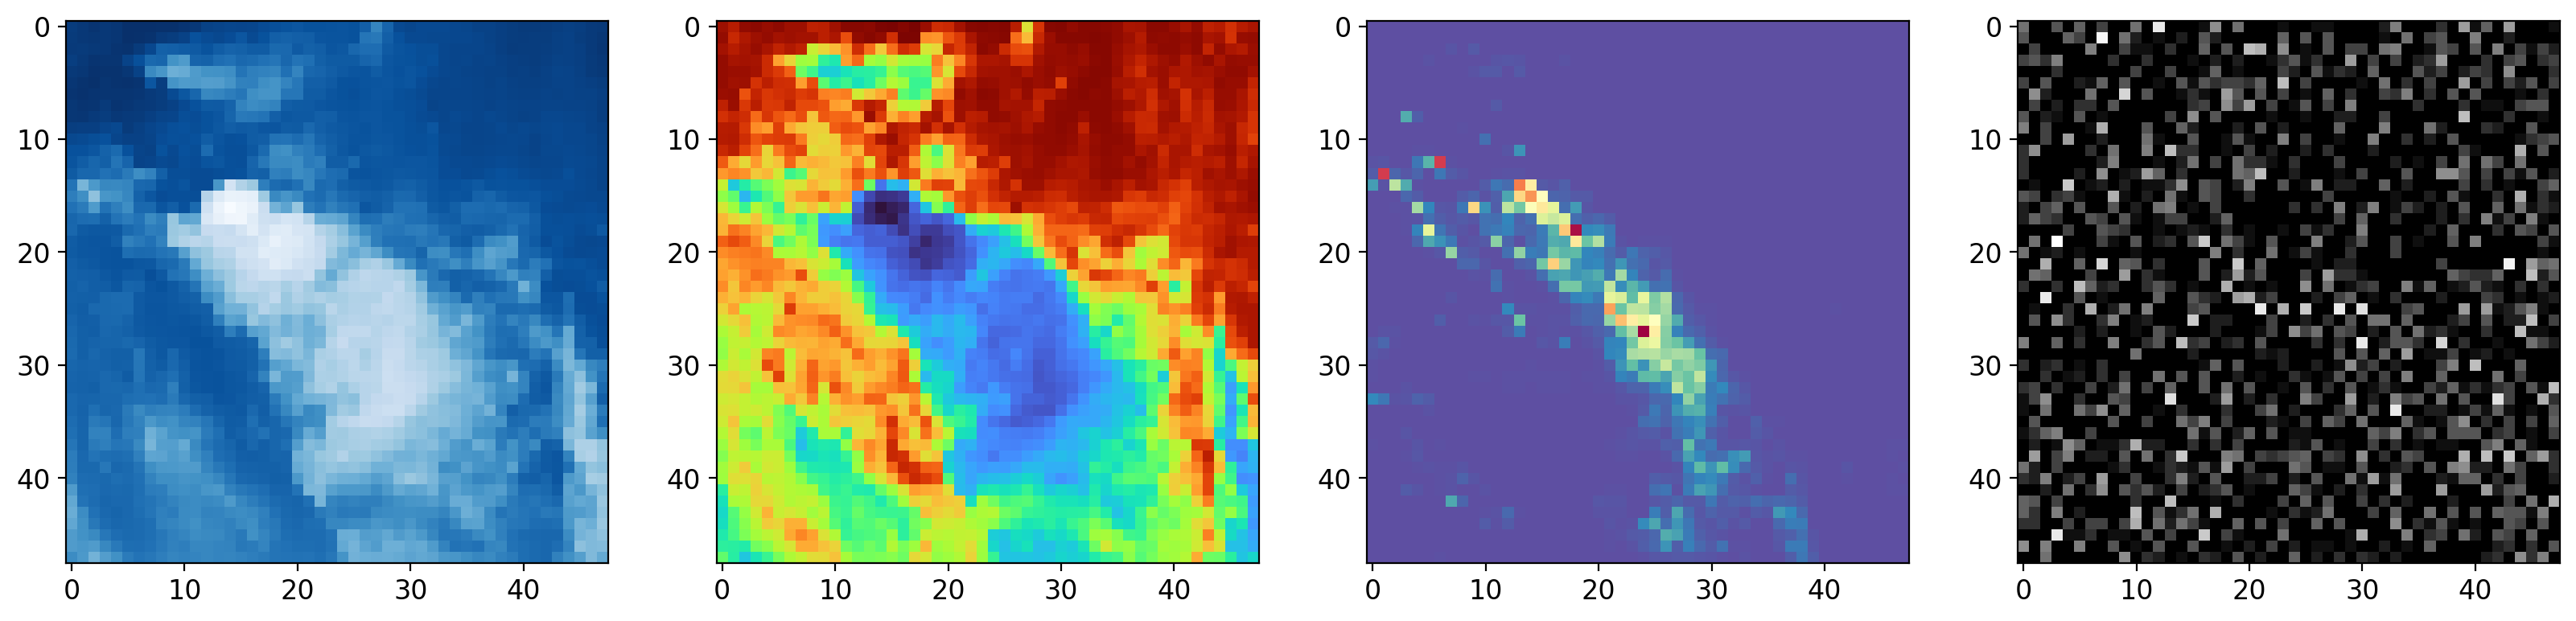

In [39]:
# Get the features for example 12 in this batch
# Permute back to (H, W, C) for plotting: (1, 2, 0)
one_example_features = features_batch[12].permute(1, 2, 0)
# Get the label for that same example
one_example_label = labels_batch[12]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

print(f"Label: {one_example_label.item()}")


 there ya go! Now you have a way to dig into the data when they are in this DataLoader form.



 Just know that if you recreate the iterator or loop again, you will get a new (random) batch.

 #### Step 5: Build CNN model



 We will define a Python class inheriting from `nn.Module` to build our CNN.



 Let's start simple with the following:



 1) A single convolutional layer with 3x3 filters and 1 output map.



In [40]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Input channels = 4 (from dataset), Output channels = 1 (1 feature map)
        # Kernel size = 3
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=3)

        self.flatten = nn.Flatten()  # flatten 2d output to 1d vector

        # We need to calculate the input size for the dense layer.
        # Input (48, 48) -> Conv2d(kernel=3, no padding) -> Output (46, 46)
        # 46 * 46 * 1 = 2116
        self.fc = nn.Linear(46 * 46, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.flatten(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

import torch.nn.functional as F

model = SimpleCNN().to(device)
print(model)


SimpleCNN(
  (conv1): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=2116, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


 #### Step 6: Run some data through



 It can be useful to run your data through the untrained model to see how it performs with completely random weights.

(0.0, 1.0)

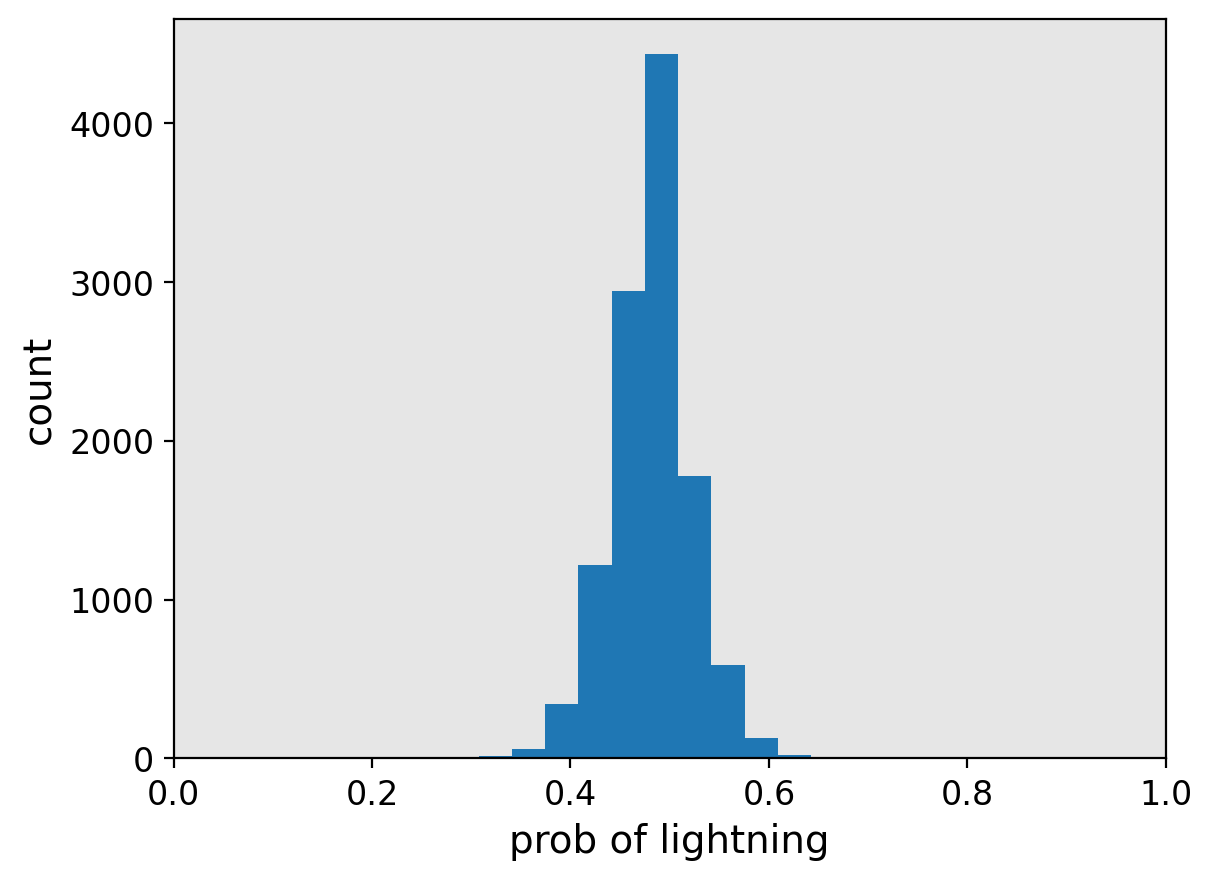

In [41]:
# Helper function to get predictions
def get_predictions(loader, model):
    model.eval() # Set model to evaluation mode
    all_preds = []
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            preds = model(inputs)
            all_preds.extend(preds.cpu().numpy())
    return np.array(all_preds).flatten()

y_preds = get_predictions(val_loader, model)

plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])


 As expected, the model is producing predictions [0,1], and the predictions generally fall in the middle of the probability distribution.



 Let's take a look at the performance diagram. To do that, we first need to extract the truth labels from our validation set.

In [42]:
y_v = ds_val.label_1d_class.values


In [43]:
# Calculate performance metrics manually using numpy
thresh = np.arange(0.05, 1.05, 0.05)

tps = []
fps = []
fns = []

for t in thresh:
    # Binarize predictions based on threshold
    preds_bin = (y_preds >= t).astype(int)

    # Calculate TP, FP, FN
    tp = np.sum((preds_bin == 1) & (y_v == 1))
    fp = np.sum((preds_bin == 1) & (y_v == 0))
    fn = np.sum((preds_bin == 0) & (y_v == 1))

    tps.append(tp)
    fps.append(fp)
    fns.append(fn)

tps = np.array(tps)
fps = np.array(fps)
fns = np.array(fns)

# Calc x,y of performance diagram
# Avoid division by zero
pods = np.divide(tps, (tps + fns), out=np.zeros_like(tps, dtype=float), where=(tps + fns)!=0)
srs = np.divide(tps, (tps + fps), out=np.zeros_like(tps, dtype=float), where=(tps + fps)!=0)
csis = np.divide(tps, (tps + fns + fps), out=np.zeros_like(tps, dtype=float), where=(tps + fns + fps)!=0)


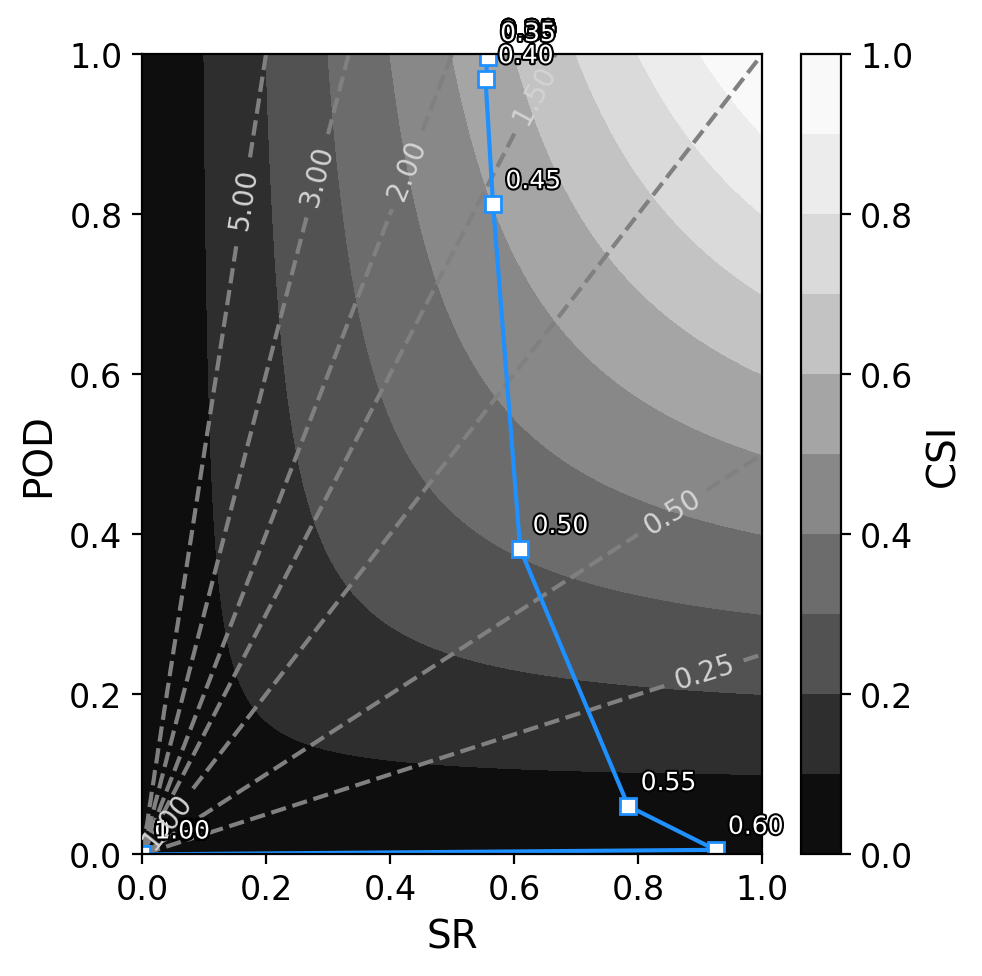

In [44]:
#import some helper functions for our other directory.
import sys
sys.path.insert(1, 'WAF_ML_Tutorial_Part2/scripts/')

#load contingency_table func
from gewitter_functions import make_performance_diagram_axis

#plot it up
ax = make_performance_diagram_axis()
ax.plot(srs, pods, '-s', color='dodgerblue', markerfacecolor='w', label='UNET')

for i, t in enumerate(thresh):
    text = np.char.ljust(str(np.round(t, 2)), width=4, fillchar='0')
    ax.text(srs[i]+0.02, pods[i]+0.02, text, path_effects=pe1, fontsize=9, color='white')

plt.tight_layout()


 There are some funky things to note with this performance diagram. It might seem like random weights work well, but remember that the validation dataset is roughly balanced (no lightning: 44%; lightning: 56%), so even a random guess can demonstrate decent performance. Also notice how the curve appears disjoint.



 If you want to view the convolution filters, you can access the weights of the layer directly:

In [45]:
# Grab layer 1 weights
filters = model.conv1.weight.data.cpu().numpy()

# PyTorch weights are (Out_Channels, In_Channels, H, W) -> (1, 4, 3, 3)
print(filters.shape)


(1, 4, 3, 3)


 Let's take a look at each of the filters (channels).

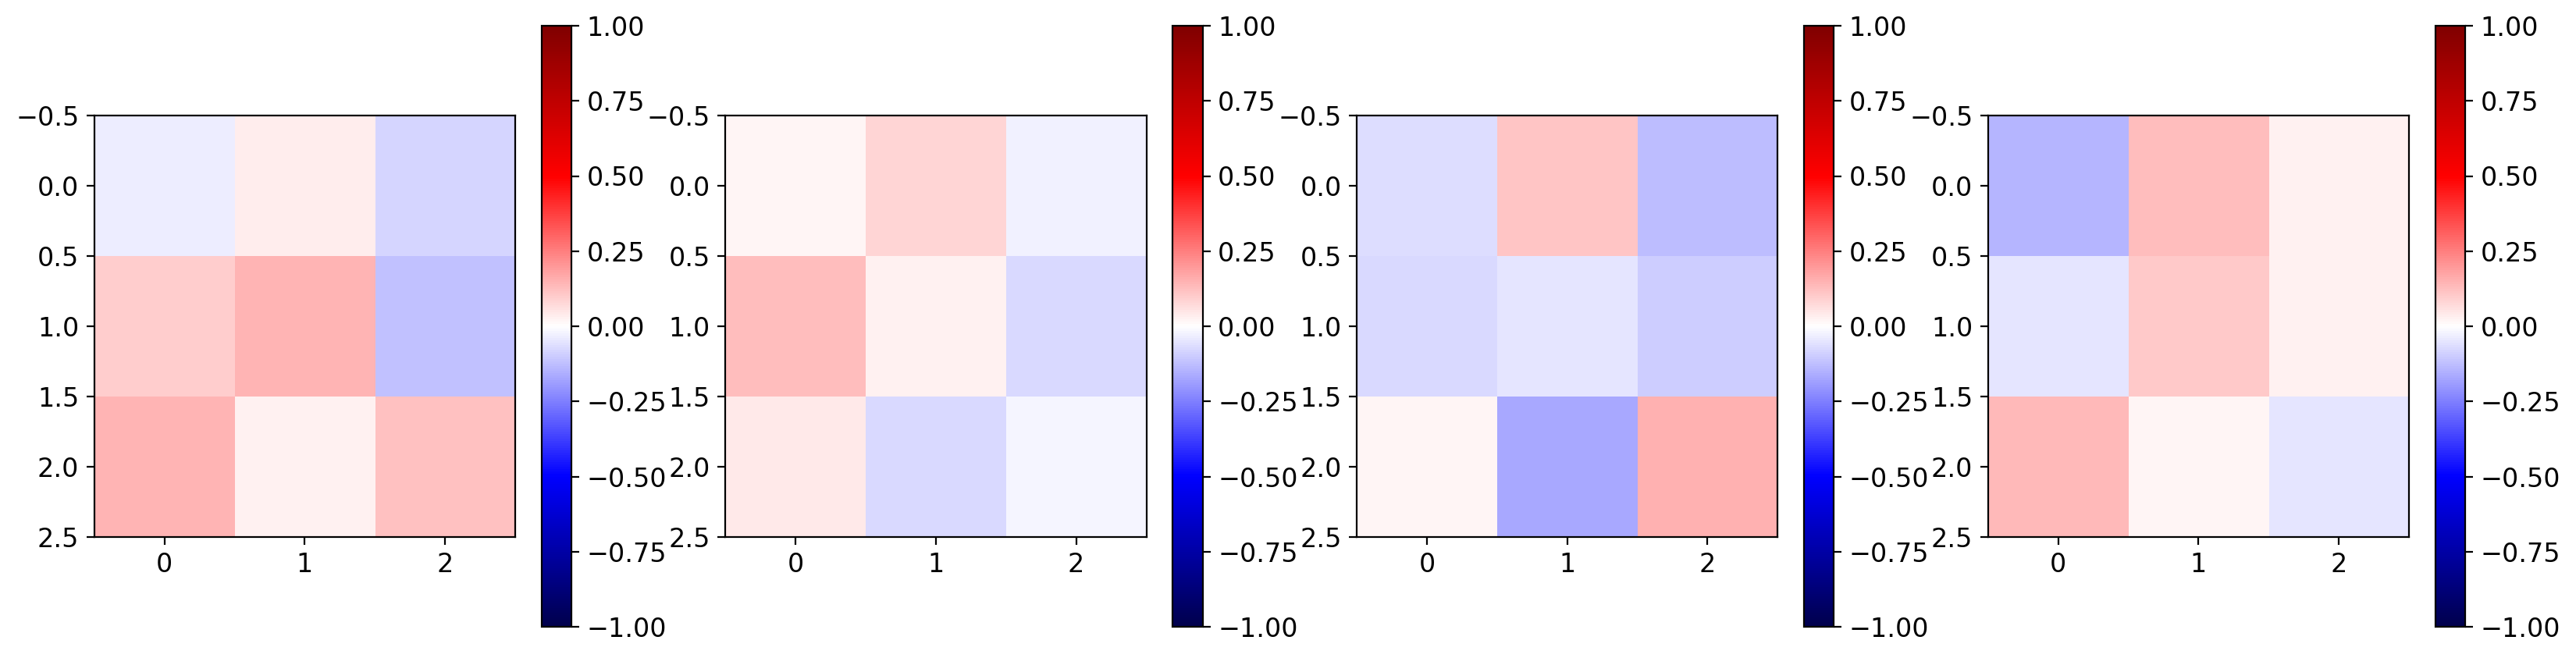

In [46]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Iterate over the input channels (second dimension)
for i in range(4):
    # filters[0, i, :, :] gives the filter for the ith input channel
    pm = axes[i].imshow(filters[0, i, :, :], vmin=-1, vmax=1, cmap='seismic')
    plt.colorbar(pm, ax=axes[i])



 This really isn't very informative, but you can see how the values are approximately equally distributed around 0. This distribution is provided in the initialization step when first creating the model.



 Maybe looking at the output of the convolutional layer will help? We can do this by creating a hook or simply passing data through the first part of the model manually.



In [16]:
# Run the model conv layer only
# Grab a batch to look at
data_iter = iter(val_loader)
features, labels = next(data_iter)

# Move to device
features = features.to(device)

# Pass through conv1
with torch.no_grad():
    convolved_images = model.conv1(features)

convolved_images = convolved_images.cpu().numpy()


Label: 0.0


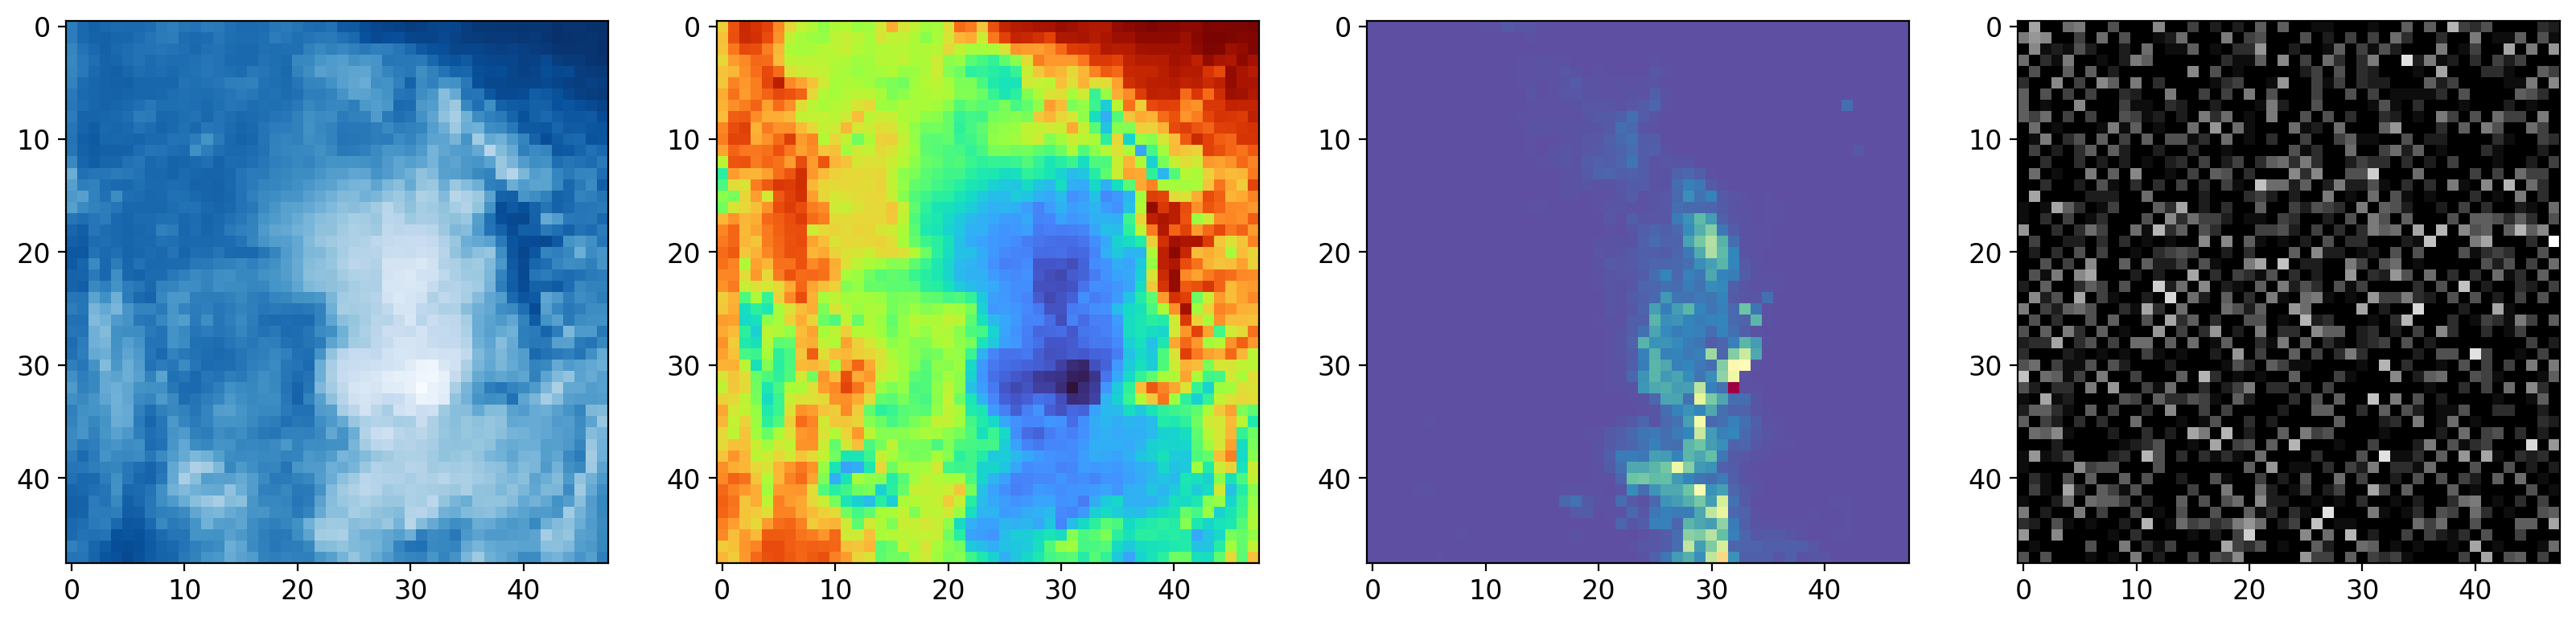

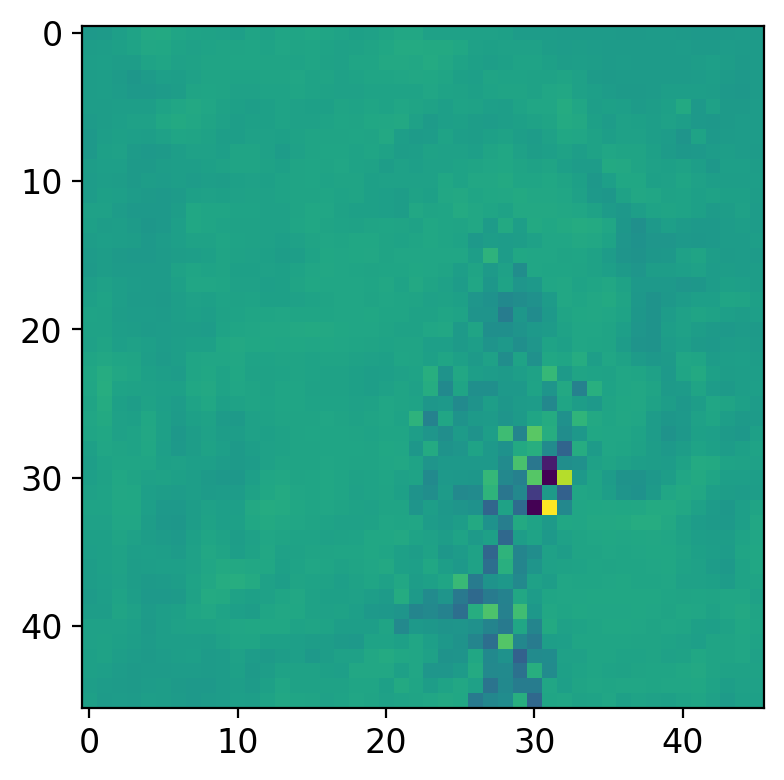

In [47]:
# Get the features for example 0 in this batch
one_example_features = features[0].permute(1, 2, 0).cpu() # Back to H,W,C for plotting
one_example_label = labels[0]

fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

print(f"Label: {one_example_label}")

plt.figure(figsize=(4.4,5))
# Convolved image shape is (Batch, Out_Channels, H, W).
# We want example 0, channel 0:
plt.imshow(convolved_images[0, 0, :, :])


 Notice that even for completely random filter weights (i.e., no training), the CNN still highlights the region where a storm is. This is probably why the performance diagram looks decent.

 #### Step 7: Train the model for 20 epochs



 Okay, enough digging in the weeds. Let's write our training loop!

In [48]:
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

epochs = 20
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train() # Set to train mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # Zero gradients
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs.squeeze(), labels) # Calculate loss
        loss.backward() # Backprop
        optimizer.step() # Update weights

        running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation loop
    model.eval() # Set to eval mode
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")


Epoch 1/20 - Loss: 0.4001 - Val Loss: 0.3187
Epoch 2/20 - Loss: 0.3225 - Val Loss: 0.2904
Epoch 3/20 - Loss: 0.3139 - Val Loss: 0.2878
Epoch 4/20 - Loss: 0.3096 - Val Loss: 0.2923
Epoch 5/20 - Loss: 0.3045 - Val Loss: 0.3060
Epoch 6/20 - Loss: 0.3051 - Val Loss: 0.3029
Epoch 7/20 - Loss: 0.2990 - Val Loss: 0.3095
Epoch 8/20 - Loss: 0.2986 - Val Loss: 0.3056
Epoch 9/20 - Loss: 0.2939 - Val Loss: 0.3050
Epoch 10/20 - Loss: 0.2952 - Val Loss: 0.3038
Epoch 11/20 - Loss: 0.2950 - Val Loss: 0.3164
Epoch 12/20 - Loss: 0.2949 - Val Loss: 0.3186
Epoch 13/20 - Loss: 0.2925 - Val Loss: 0.3284
Epoch 14/20 - Loss: 0.2931 - Val Loss: 0.3287
Epoch 15/20 - Loss: 0.2950 - Val Loss: 0.3303
Epoch 16/20 - Loss: 0.2977 - Val Loss: 0.3299
Epoch 17/20 - Loss: 0.2986 - Val Loss: 0.3304
Epoch 18/20 - Loss: 0.2952 - Val Loss: 0.3351
Epoch 19/20 - Loss: 0.2960 - Val Loss: 0.3440
Epoch 20/20 - Loss: 0.2956 - Val Loss: 0.3392


 Depending on your computer, this might take some time to run.



 #### Step 8: Check for overfitting



 As always, we should probably check to see if the model is overfitting. To do this, let's plot the loss curves for both the training data and the validation data:

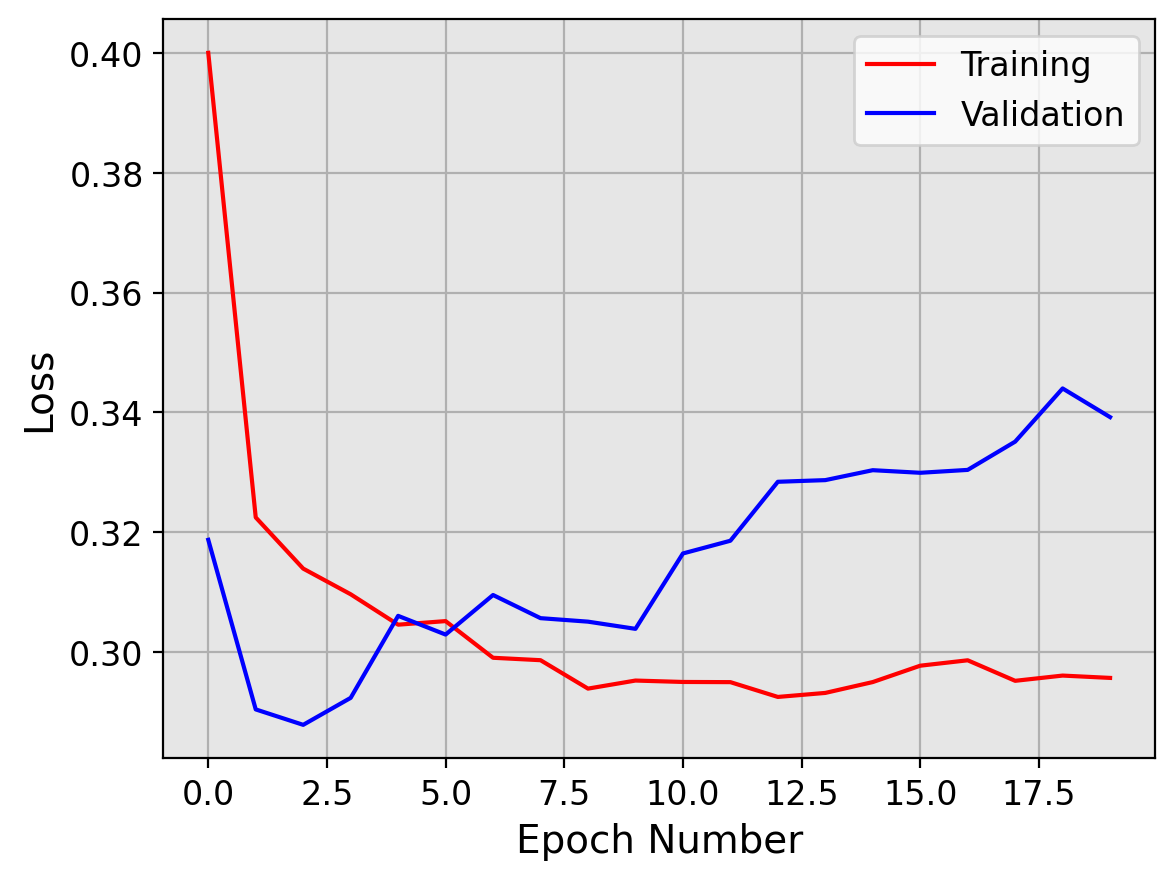

In [49]:
plt.plot(train_losses, '-r', label='Training')
plt.plot(val_losses, '-b', label='Validation')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid()


 Take a moment and consider if overfitting has occurred. Remember, you are looking to see if the red line continues to decrease while the blue line increases.



 In this example, I would say that the model has probably begun to overfit. Specifically, the validation loss begins to consistently increase around epoch 3. Let's check on the overall performance anyway.



 #### Step 9: Check performance



 To check the performance, we can reuse the same code from earlier in this tutorial:

(0.0, 1.0)

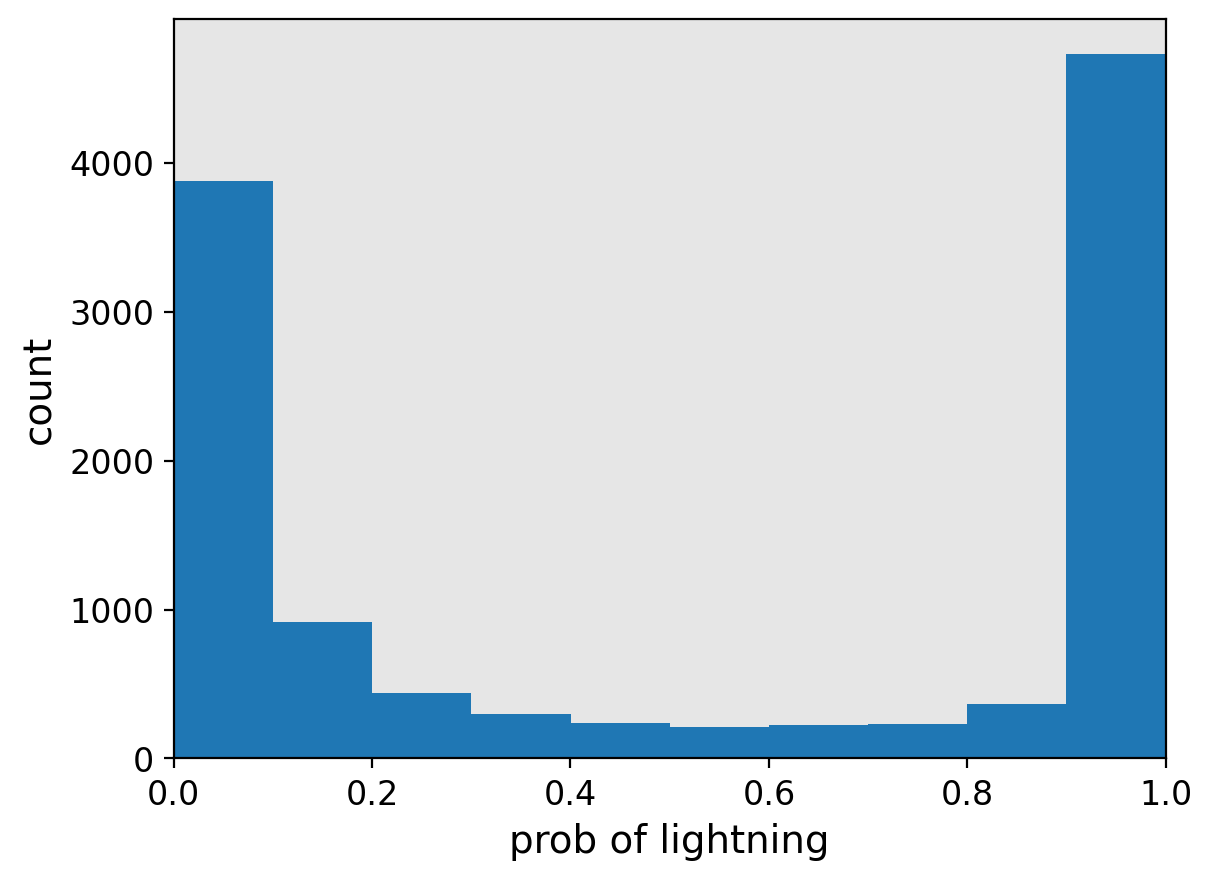

In [50]:
y_preds = get_predictions(val_loader, model)

plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])


 Here we can see there is a good grouping of examples where the model predicts class probabilities near 0 and 1, and then there are relatively few cases where the output of the model is more in the middle of the distribution (i.e., more uncertain).



 Let's make the performance diagram again:

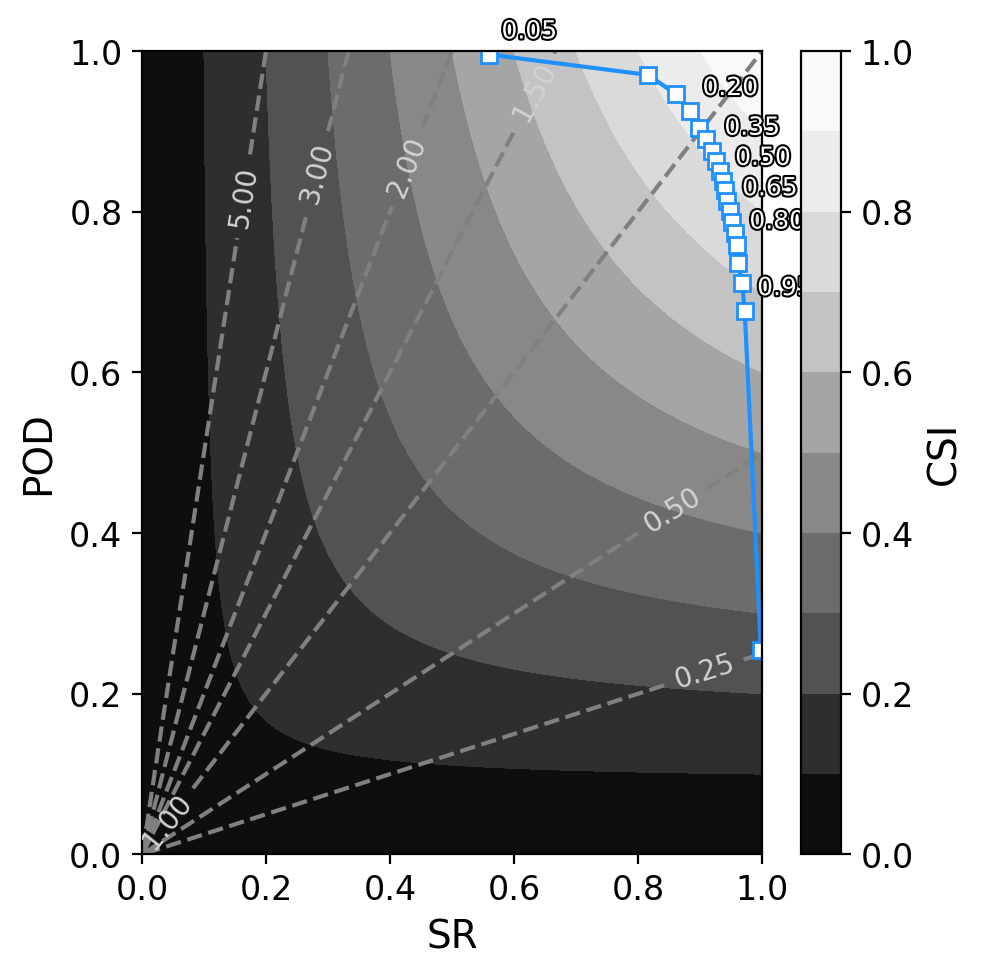

In [51]:
thresh = np.arange(0.05, 1.05, 0.05)

tps = []
fps = []
fns = []

for t in thresh:
    preds_bin = (y_preds >= t).astype(int)
    tps.append(np.sum((preds_bin == 1) & (y_v == 1)))
    fps.append(np.sum((preds_bin == 1) & (y_v == 0)))
    fns.append(np.sum((preds_bin == 0) & (y_v == 1)))

tps = np.array(tps)
fps = np.array(fps)
fns = np.array(fns)

pods = np.divide(tps, (tps + fns), out=np.zeros_like(tps, dtype=float), where=(tps + fns)!=0)
srs = np.divide(tps, (tps + fps), out=np.zeros_like(tps, dtype=float), where=(tps + fps)!=0)
csis = np.divide(tps, (tps + fns + fps), out=np.zeros_like(tps, dtype=float), where=(tps + fns + fps)!=0)

#plot it up
ax = make_performance_diagram_axis()
ax.plot(srs, pods, '-s', color='dodgerblue', markerfacecolor='w', label='UNET')

for i, t in enumerate(thresh):
    if np.mod(i, 3) == 0:
        text = np.char.ljust(str(np.round(t, 2)), width=4, fillchar='0')
        ax.text(srs[i]+0.02, pods[i]+0.02, text, path_effects=pe1, fontsize=9, color='white')

plt.tight_layout()


 We get much better results this time. The model has a maximum CSI value of about 0.81 when using a class probability of 0.2 as the deterministic threshold.



 Can we see what filter it learned?

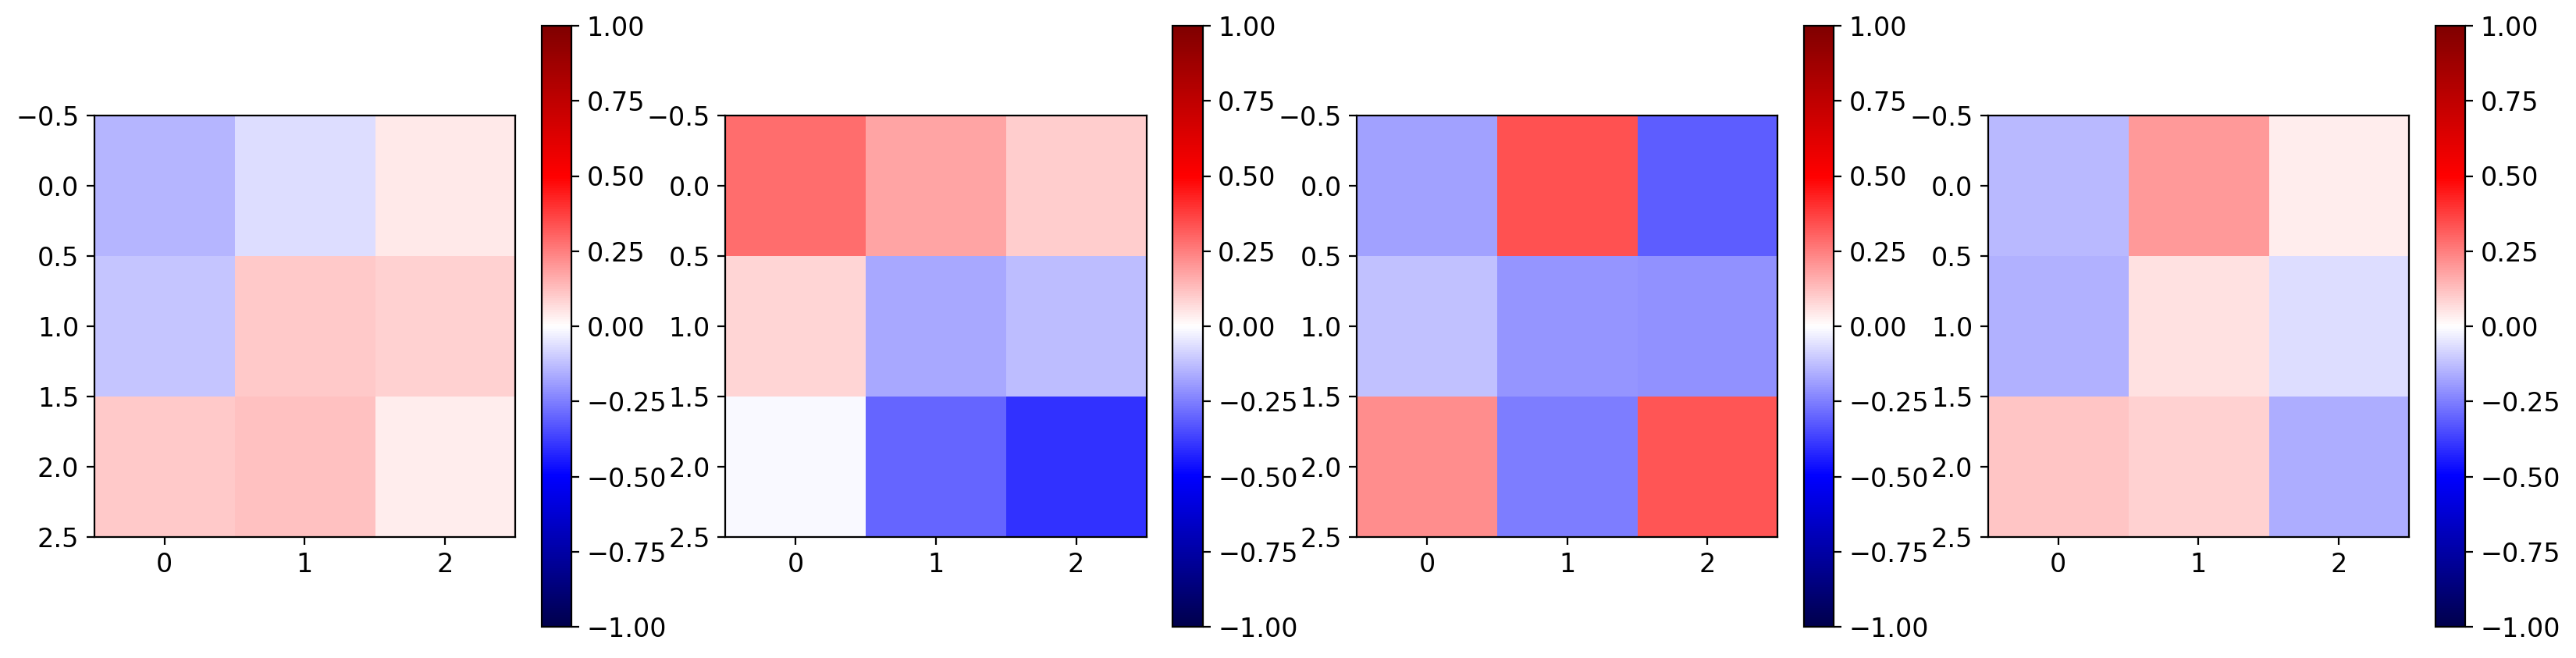

In [52]:
# Grab layer 1 weights
filters = model.conv1.weight.data.cpu().numpy()

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    pm = axes[i].imshow(filters[0, i, :, :], vmin=-1, vmax=1, cmap='seismic')
    plt.colorbar(pm, ax=axes[i])


 As before, it doesn't seem very useful to look at the kernels themselves, so let's look at the output of the convolutional layer instead.

In [53]:
# Run just the conv layer
data_iter = iter(val_loader)
features, labels = next(data_iter)
features = features.to(device)

with torch.no_grad():
    convolved_images = model.conv1(features)
convolved_images = convolved_images.cpu().numpy()


Label: 1.0


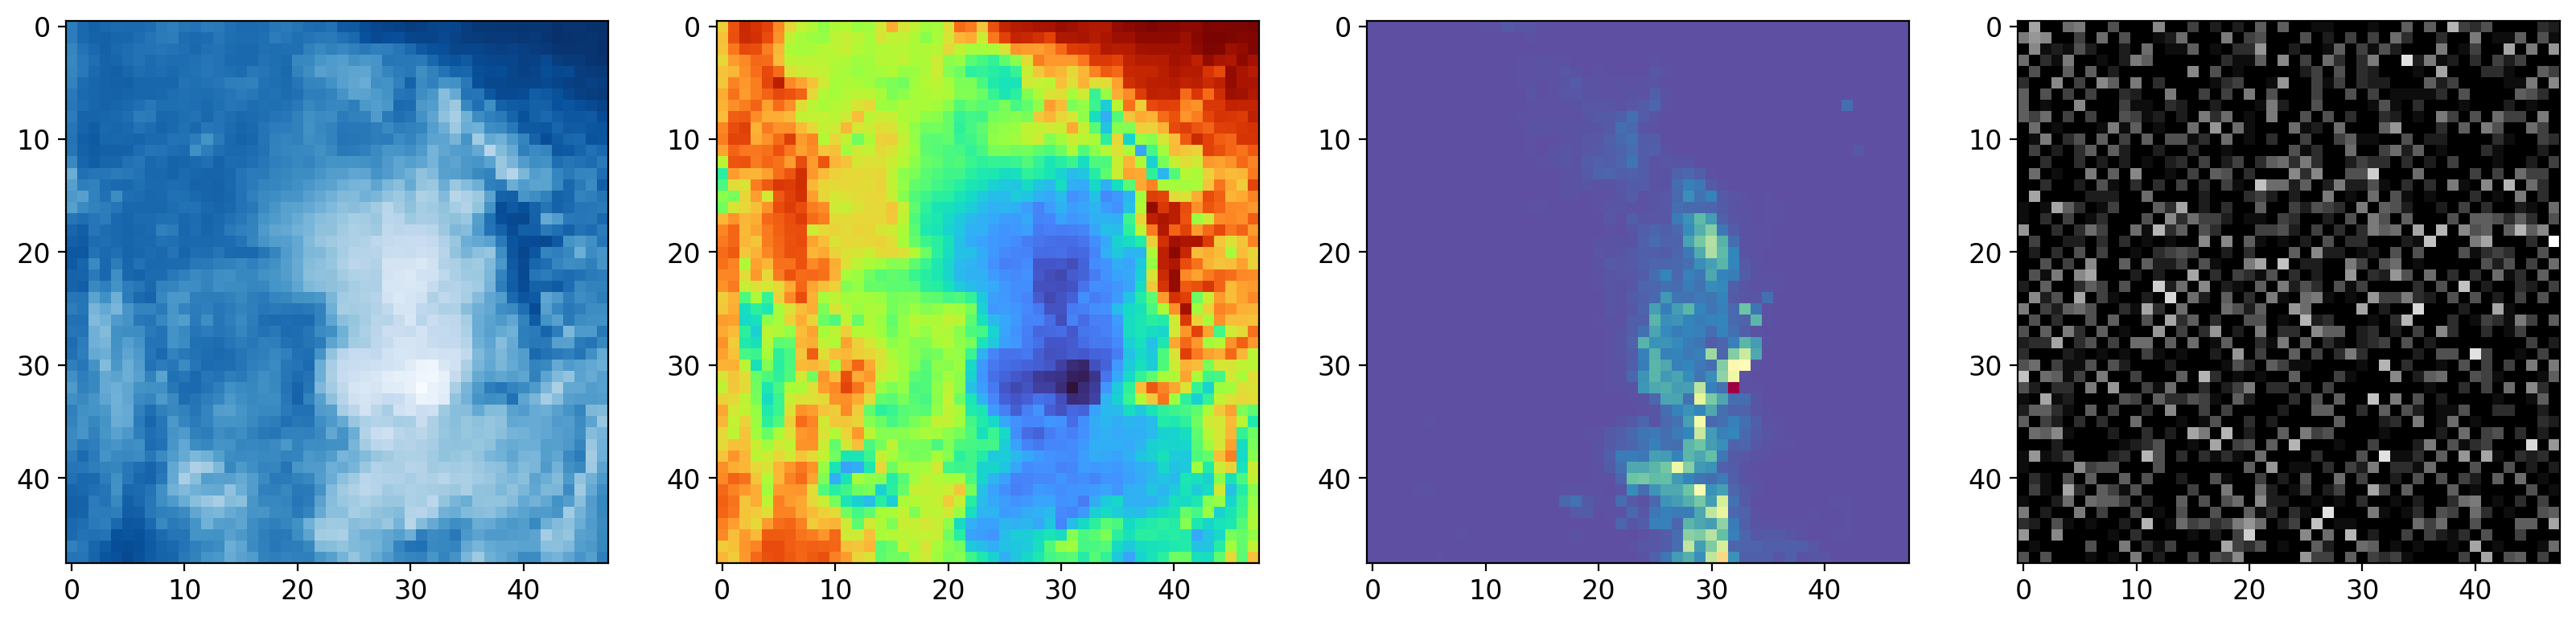

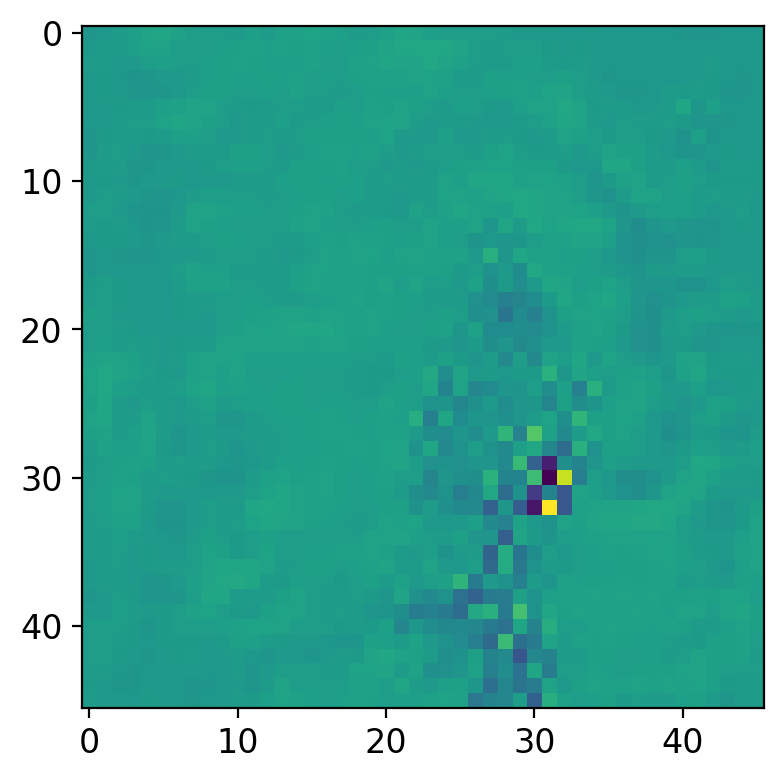

In [54]:
one_example_features = features[0].permute(1, 2, 0).cpu() # Back to HWC
one_example_label = labels[0]

fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

print(f"Label: {one_example_label}")

plt.figure(figsize=(4.4,5))
plt.imshow(convolved_images[0, 0, :, :])


 The result here is actually quite similar to the untrained model, although the convolved data does look a bit more 'focused' in on the area where there are cold cloud tops and high radar values.



 This is probably not a very satisfying explanation for trained models behavior. Thus, later on in this tutorial series there is a notebook discussing more quantitative methods for explaining the CNN.



 #### Step 10: Save the model



 Since this model performs pretty well, let's go ahead and save it.

In [55]:
torch.save(model.state_dict(), 'WAF_ML_Tutorial_Part2/datasets/models/neural_nets_from_notebooks/MyFirstCNN.pth')


 #### Step 11: Add an ANN



 Typically CNNs have their convolution and maxpool layers, but then after some number of them, the convolutional data is fed through an ANN. This task seems to do well with just a single convolutional layer, but for the sake of completeness, let's add an ANN.

In [56]:
class ComplexCNN(nn.Module):
    def __init__(self):
        super(ComplexCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=3)
        self.flatten = nn.Flatten()

        # Conv output is 46x46
        self.fc1 = nn.Linear(46 * 46, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 1) # Output layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

model = ComplexCNN().to(device)
print(model)


ComplexCNN(
  (conv1): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2116, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


 Now you can see there are a few more trainable parameters (i.e., weights).



 #### Step 12: Train the new model

In [57]:
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")


Epoch 1/10 - Loss: 0.2817 - Val Loss: 0.2657
Epoch 2/10 - Loss: 0.2318 - Val Loss: 0.2747
Epoch 3/10 - Loss: 0.2143 - Val Loss: 0.3020
Epoch 4/10 - Loss: 0.1962 - Val Loss: 0.3260
Epoch 5/10 - Loss: 0.1788 - Val Loss: 0.3427
Epoch 6/10 - Loss: 0.1629 - Val Loss: 0.4164
Epoch 7/10 - Loss: 0.1458 - Val Loss: 0.4508
Epoch 8/10 - Loss: 0.1299 - Val Loss: 0.5230
Epoch 9/10 - Loss: 0.1166 - Val Loss: 0.5680
Epoch 10/10 - Loss: 0.1039 - Val Loss: 0.6494


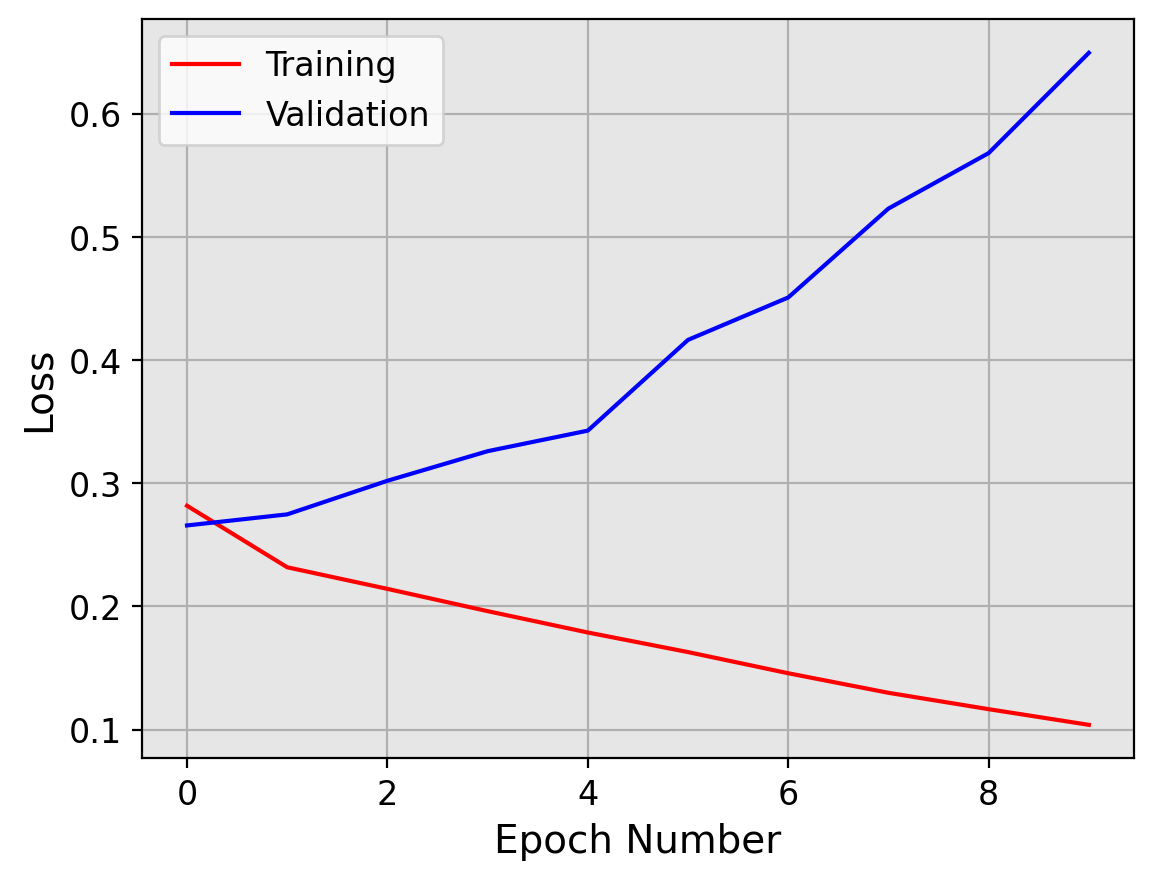

In [58]:
plt.plot(train_losses, '-r', label='Training')
plt.plot(val_losses, '-b', label='Validation')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid()


 This is a clear overfitting signature. It would seem that adding these extra parameters did not help our model.



 #### Step 13: Add regularization (fix overfitting)



 This is a good time to introduce some regularization tips that can help avoid overfitting. First, let's try adding dropout. This is where neurons are randomly turned on/off to prevent the neural network from memorizing examples (i.e., a specific pathway for a specific example in your training dataset).

In [59]:
class RegularizedCNN(nn.Module):
    def __init__(self):
        super(RegularizedCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=3)
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(46 * 46, 16)
        self.dropout1 = nn.Dropout(0.33) # 33% dropout
        self.fc2 = nn.Linear(16, 32)
        self.dropout2 = nn.Dropout(0.33) # 33% dropout
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x) # Apply dropout

        x = F.relu(self.fc2(x))
        x = self.dropout2(x) # Apply dropout

        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

model = RegularizedCNN().to(device)
print(model)


RegularizedCNN(
  (conv1): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2116, out_features=16, bias=True)
  (dropout1): Dropout(p=0.33, inplace=False)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (dropout2): Dropout(p=0.33, inplace=False)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [60]:
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")


Epoch 1/10 - Loss: 0.3557 - Val Loss: 0.2627
Epoch 2/10 - Loss: 0.2772 - Val Loss: 0.2570
Epoch 3/10 - Loss: 0.2678 - Val Loss: 0.2796
Epoch 4/10 - Loss: 0.2596 - Val Loss: 0.2553
Epoch 5/10 - Loss: 0.2546 - Val Loss: 0.2774
Epoch 6/10 - Loss: 0.2496 - Val Loss: 0.2646
Epoch 7/10 - Loss: 0.2380 - Val Loss: 0.2867
Epoch 8/10 - Loss: 0.2267 - Val Loss: 0.2890
Epoch 9/10 - Loss: 0.2225 - Val Loss: 0.2893
Epoch 10/10 - Loss: 0.2169 - Val Loss: 0.3117


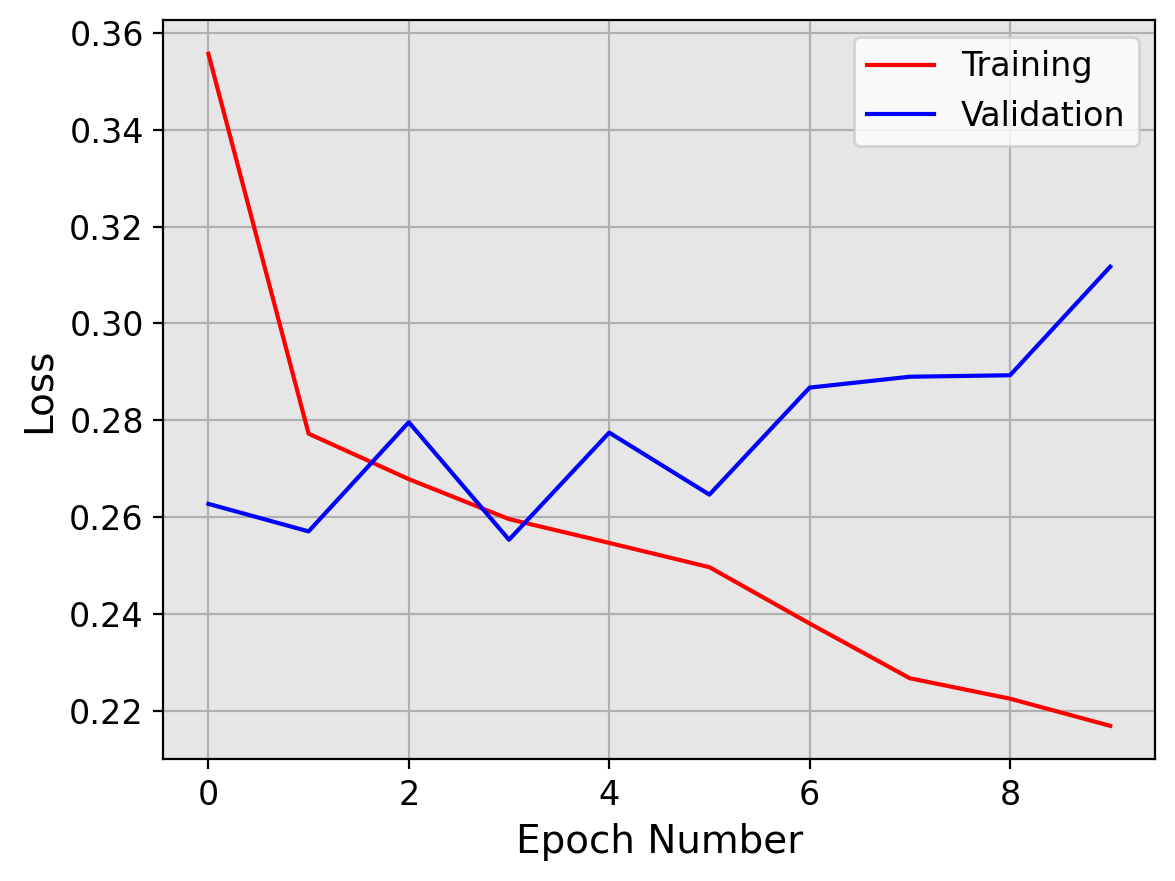

In [61]:
plt.plot(train_losses, '-r', label='Training')
plt.plot(val_losses, '-b', label='Validation')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid()


 As you can see here, the dropout seems to have prevented much of the overfitting signal. However, there may still be some slight overfitting here from about epoch 5 on.



 #### Step 14: Check performance again

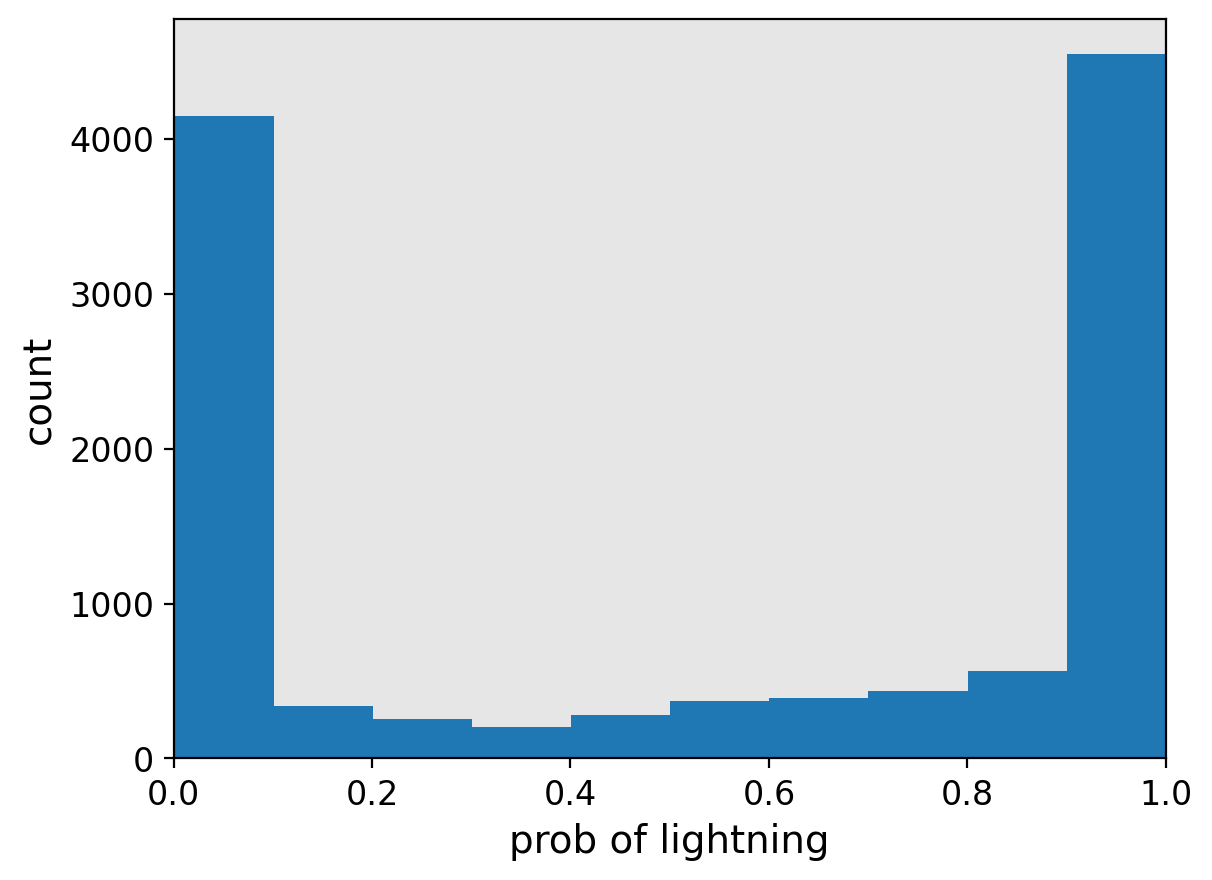

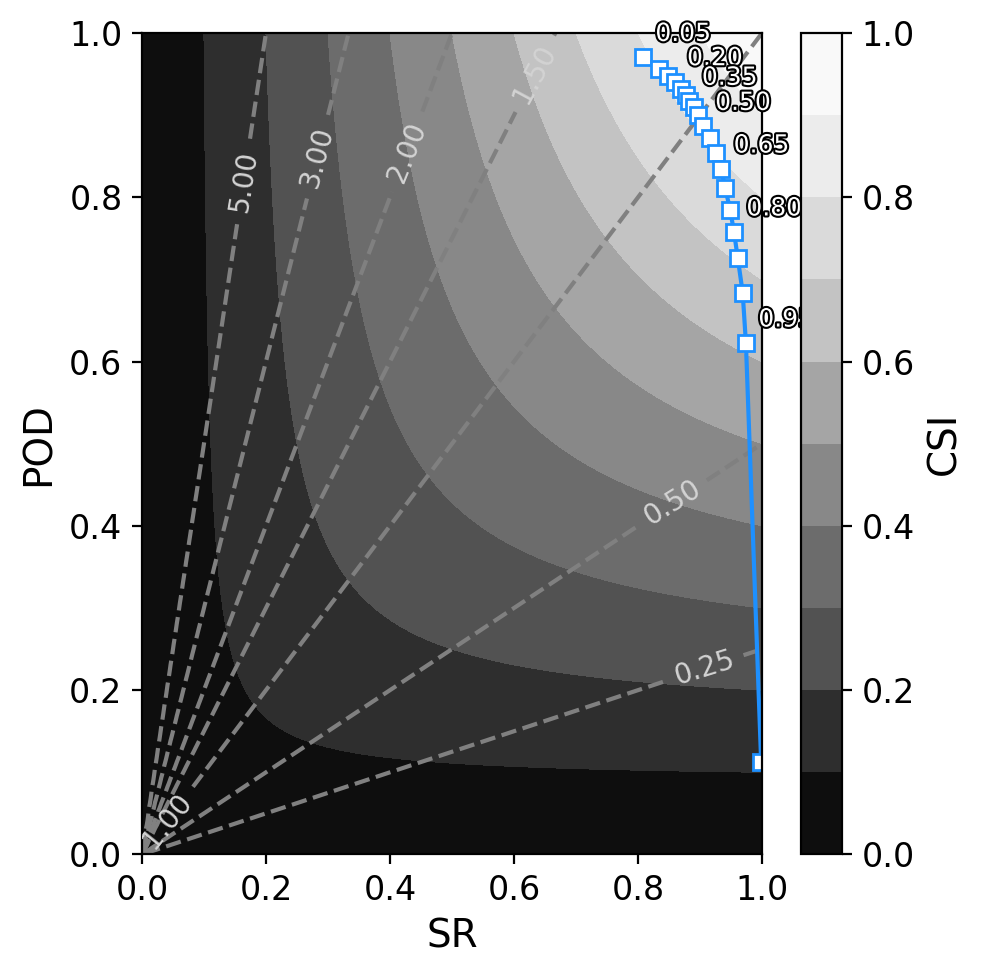

In [62]:
# Get predictions
y_preds = get_predictions(val_loader, model)

plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])

# Calculate performance diagram metrics
thresh = np.arange(0.05, 1.05, 0.05)

tps = []
fps = []
fns = []

for t in thresh:
    preds_bin = (y_preds >= t).astype(int)
    tps.append(np.sum((preds_bin == 1) & (y_v == 1)))
    fps.append(np.sum((preds_bin == 1) & (y_v == 0)))
    fns.append(np.sum((preds_bin == 0) & (y_v == 1)))

tps = np.array(tps)
fps = np.array(fps)
fns = np.array(fns)

pods = np.divide(tps, (tps + fns), out=np.zeros_like(tps, dtype=float), where=(tps + fns)!=0)
srs = np.divide(tps, (tps + fps), out=np.zeros_like(tps, dtype=float), where=(tps + fps)!=0)
csis = np.divide(tps, (tps + fns + fps), out=np.zeros_like(tps, dtype=float), where=(tps + fns + fps)!=0)

#plot it up
ax = make_performance_diagram_axis()
ax.plot(srs, pods, '-s', color='dodgerblue', markerfacecolor='w', label='UNET')

for i, t in enumerate(thresh):
    if np.mod(i, 3) == 0:
        text = np.char.ljust(str(np.round(t, 2)), width=4, fillchar='0')
        ax.text(srs[i]+0.02, pods[i]+0.02, text, path_effects=pe1, fontsize=9, color='white')

plt.tight_layout()


 There ya go! You have trained a more typical CNN structure.



 The next notebook will dive into using U-nets, which will not only tell us if there is lightning in the image but also where that lightning is.